In [1]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# remove useless Tensorflow warning:
# WARNING:absl:Found untraced functions such as _update_step_xla, lstm_cell_1_layer_call_fn, 
# lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, 
# lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 5). 
# These functions will not be directly callable after loading.
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

#### RNN: Formula Label Prediction (Variant 2: Stream of math type tokens)

In [3]:
import numpy as np 
import pandas as pd
from pathlib import Path 

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import datetime

tfds.disable_progress_bar()
wandb_project_name = "binary_formula_classification"

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [5]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["type_tokens"] = corpus["type_tokens"].map(process_cell)

In [6]:
#print(os.getcwd())
data_p = Path("../data/") / "bin_class_data_TOKENIZED_SET_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()


,tokens,type_tokens,label
0,"['f', ':', 'A', '\\to', 'B']",func_def func_name __ANON_1 COLON mapping __AN...,1
1,['f'],func_name __ANON_1,1
2,"['g', '\\colon', 'B', '\\to', 'I']",func_def func_name __ANON_1 COLON mapping __AN...,1
3,"['\\frac', '{', '8', '!', '}', '{', '(', '8', ...",expr_atom CMD_FRAC L_BRACE postfix expr_atom _...,1
4,['f'],func_name __ANON_1,1


In [7]:
SIZE_TRAIN_DS = 10000
SIZE_TEST_DS = 1000
data_as_ds = tf.data.Dataset.from_tensor_slices((data["type_tokens"], data["label"])) 
test_dataset = data_as_ds.take(SIZE_TEST_DS)
train_dataset = data_as_ds.skip(SIZE_TEST_DS)

##### Setup and Data Preparation

In [8]:
for example, label in train_dataset.take(1):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

text:  b'func_name __ANON_1'
label:  1


In [9]:
BUFFER_SIZE = SIZE_TRAIN_DS
BATCH_SIZE = 64
STEPS_PER_EPOCH = np.floor(SIZE_TRAIN_DS/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.floor(SIZE_TEST_DS/BATCH_SIZE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [10]:
def create_encoder(output_mode_str, n_grams):
    VOCAB_SIZE = 1000
    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        split="whitespace",
        max_tokens=VOCAB_SIZE)
    encoder.adapt(train_dataset.map(lambda tokens, label: tokens)) # removes the label column through transformation: text, label -> text
    return encoder

##### Representation 1: Use integer indices encoding

In [11]:
encoder_int = create_encoder("int", None)
vocab = np.array(encoder_int.get_vocabulary())
vocab_size = len(encoder_int.get_vocabulary())
print("vocabulary size: ", vocab_size)
vocab[:200]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
vocabulary size:  59


array(['', '[UNK]', '__ANON_1', '__ANON_3', 'expr_atom', 'func_name',
       '__ANON_0', 'COLON', 'mapping', 'func_def', 'TO', 'additive',
       'CARET', 'unary', 'L_PAREN', 'R_PAREN', 'integer', 'R_BRACE',
       'L_BRACE', 'exp', 'ADD', 'set_constant', 'SET_BASIC', 'SUB',
       'item', 'group', 'COMMA', 'func_name_arg', 'func_expr', 'EQUAL',
       'set_expr', 'CMD_FRAC', 'R_BRACE_LITERAL', 'L_BRACE_LITERAL',
       'explset', 'SET_FAT', 'mp', 'set_enumeration', 'interval',
       'sets__OP_CART', 'DIV', 'UNC_NORMA', 'number', 'R_BRACKET',
       'L_BRACKET', 'sets__OP_UNION', 'sets__OP_INTERSEC', 'CMD_CDOT',
       'func_arg', 'postfix', 'BANG', 'OP_FUNC_COMP', 'func_composed',
       'et_constan', 'MUL', 'func_enumeration', 'CMD_TIMES',
       'FUNC_NORMAL', 'CMD_BINOM'], dtype='<U17')

In [12]:
encoded_example = encoder_int(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'func_name __ANON_1', shape=(), dtype=string)
[5 2]


In [13]:
print("Original: ", example.numpy())
print("After reverse lookup: ", " ".join(vocab[encoded_example]))

Original:  b'func_name __ANON_1'
After reverse lookup:  func_name __ANON_1


##### Representation 2: Binary Count Vectorizer

In [14]:
encoder_multi_hot = create_encoder("multi_hot", None)
vocab = np.array(encoder_multi_hot.get_vocabulary())
vocab_size = len(encoder_multi_hot.get_vocabulary())
print("vocabulary size: ", vocab_size)
vocab[:200]

vocabulary size:  58


array(['[UNK]', '__ANON_1', '__ANON_3', 'expr_atom', 'func_name',
       '__ANON_0', 'COLON', 'mapping', 'func_def', 'TO', 'additive',
       'CARET', 'unary', 'L_PAREN', 'R_PAREN', 'integer', 'exp',
       'R_BRACE', 'L_BRACE', 'ADD', 'set_constant', 'SET_BASIC', 'SUB',
       'item', 'group', 'COMMA', 'func_name_arg', 'func_expr', 'EQUAL',
       'set_expr', 'CMD_FRAC', 'R_BRACE_LITERAL', 'L_BRACE_LITERAL',
       'explset', 'SET_FAT', 'mp', 'set_enumeration', 'sets__OP_CART',
       'interval', 'DIV', 'UNC_NORMA', 'number', 'R_BRACKET', 'L_BRACKET',
       'sets__OP_UNION', 'sets__OP_INTERSEC', 'CMD_CDOT', 'func_arg',
       'postfix', 'BANG', 'OP_FUNC_COMP', 'func_composed', 'et_constan',
       'MUL', 'func_enumeration', 'CMD_TIMES', 'FUNC_NORMAL', 'CMD_BINOM'],
      dtype='<U17')

In [15]:
encoded_example = encoder_multi_hot(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'func_name __ANON_1', shape=(), dtype=string)
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##### Representation 3: Frequency Count Vectorizer

In [16]:
encoder_count = create_encoder("count", None)
vocab = np.array(encoder_count.get_vocabulary())
vocab_size = len(encoder_count.get_vocabulary())
print("vocabulary size: ", vocab_size)
vocab[:200]

vocabulary size:  58


array(['[UNK]', '__ANON_1', '__ANON_3', 'expr_atom', 'func_name',
       '__ANON_0', 'COLON', 'mapping', 'func_def', 'TO', 'additive',
       'CARET', 'unary', 'L_PAREN', 'R_PAREN', 'integer', 'R_BRACE',
       'L_BRACE', 'exp', 'ADD', 'set_constant', 'SET_BASIC', 'SUB',
       'item', 'group', 'COMMA', 'func_name_arg', 'func_expr', 'EQUAL',
       'set_expr', 'CMD_FRAC', 'R_BRACE_LITERAL', 'L_BRACE_LITERAL',
       'explset', 'SET_FAT', 'mp', 'set_enumeration', 'sets__OP_CART',
       'interval', 'DIV', 'UNC_NORMA', 'number', 'R_BRACKET', 'L_BRACKET',
       'sets__OP_UNION', 'sets__OP_INTERSEC', 'CMD_CDOT', 'func_arg',
       'postfix', 'BANG', 'OP_FUNC_COMP', 'func_composed', 'et_constan',
       'MUL', 'func_enumeration', 'CMD_TIMES', 'FUNC_NORMAL', 'CMD_BINOM'],
      dtype='<U17')

In [17]:
encoded_example = encoder_count(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'func_name __ANON_1', shape=(), dtype=string)
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##### Representation 4: Bigrams Frequency Count Vectorizer

In [18]:
encoder_bigrams = create_encoder("count", (2))
vocab = np.array(encoder_bigrams.get_vocabulary())
vocab_size = len(encoder_bigrams.get_vocabulary())
print("vocabulary size: ", vocab_size)
vocab[:200]

vocabulary size:  355


array(['[UNK]', '__ANON_1', '__ANON_3', 'expr_atom', 'func_name',
       'func_name __ANON_1', 'expr_atom __ANON_3', '__ANON_0',
       '__ANON_3 __ANON_3', 'COLON', 'mapping', 'func_def', 'TO',
       'COLON mapping', 'func_def func_name', '__ANON_1 COLON',
       'additive', 'CARET', 'unary', 'L_PAREN', 'R_PAREN', '__ANON_0 TO',
       'integer __ANON_3', 'integer', 'expr_atom integer', 'exp',
       'R_BRACE', 'L_BRACE', 'TO __ANON_0', 'mapping __ANON_0',
       '__ANON_1 R_PAREN', 'ADD', 'set_constant',
       'set_constant SET_BASIC', 'SET_BASIC', 'SUB', 'L_PAREN __ANON_1',
       'item', 'exp __ANON_1', '__ANON_1 CARET', 'group', 'COMMA',
       'group L_PAREN', '__ANON_3 R_BRACE', 'CARET expr_atom',
       '__ANON_1 ADD', 'func_name __ANON_0', 'unary __ANON_1',
       'func_name_arg', 'func_expr func_name_arg', 'func_expr',
       'R_PAREN EQUAL', 'EQUAL', 'func_name_arg func_name',
       'additive __ANON_1', '__ANON_1 L_PAREN', 'unary expr_atom',
       'set_expr', 'SUB expr_a

In [19]:
encoded_example = encoder_bigrams(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'func_name __ANON_1', shape=(), dtype=string)
[0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

##### Representation 5: Tf-Idf Vectorizer

In [20]:
encoder_tf_idf = create_encoder("tf_idf", None)
vocab = np.array(encoder_tf_idf.get_vocabulary())
vocab_size = len(encoder_tf_idf.get_vocabulary())
print("vocabulary size: ", vocab_size)
vocab[:200]

vocabulary size:  58


array(['[UNK]', '__ANON_1', '__ANON_3', 'expr_atom', 'func_name',
       '__ANON_0', 'COLON', 'mapping', 'func_def', 'TO', 'additive',
       'CARET', 'unary', 'L_PAREN', 'R_PAREN', 'integer', 'exp',
       'R_BRACE', 'L_BRACE', 'ADD', 'set_constant', 'SET_BASIC', 'SUB',
       'item', 'group', 'COMMA', 'func_name_arg', 'func_expr', 'EQUAL',
       'set_expr', 'CMD_FRAC', 'R_BRACE_LITERAL', 'L_BRACE_LITERAL',
       'explset', 'SET_FAT', 'mp', 'set_enumeration', 'interval',
       'sets__OP_CART', 'DIV', 'UNC_NORMA', 'number', 'R_BRACKET',
       'L_BRACKET', 'sets__OP_UNION', 'sets__OP_INTERSEC', 'CMD_CDOT',
       'func_arg', 'postfix', 'BANG', 'OP_FUNC_COMP', 'func_composed',
       'et_constan', 'MUL', 'func_enumeration', 'CMD_TIMES',
       'FUNC_NORMAL', 'CMD_BINOM'], dtype='<U17')

In [21]:
encoded_example = encoder_tf_idf(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'func_name __ANON_1', shape=(), dtype=string)
[0.         0.97837365 0.         0.         1.0944893  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


##### Model (Bidirectional LSTM with one layer)

 **Define and compile model**

In [22]:
def create_model(vec_encoder, add_inp_emb_dim=1):
    embedding_input_dim = len(vec_encoder.get_vocabulary())+add_inp_emb_dim
    model = tf.keras.Sequential([
        vec_encoder,
        tf.keras.layers.Embedding(
            input_dim= embedding_input_dim,
            output_dim=64,
            # user masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    return model

 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [23]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [24]:
model = create_model(encoder_int)
sample_text = "( A \cup B ) \cap (C \cup D )"
# predict on a sample formula using untrained model
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.01784826]


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          3840      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 78,209
Trainable params: 78,209
Non-traina

In [26]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [27]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "2-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "int",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
155/156 [============================>.] - ETA: 0s - loss: 0.6431 - accuracy: 0.5509INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


156/156 [==============================] - 23s 118ms/step - loss: 0.6427 - accuracy: 0.5503 - val_loss: 0.6735 - val_accuracy: 0.0073
Epoch 2/15
154/156 [============================>.] - ETA: 0s - loss: 0.5014 - accuracy: 0.6927INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


156/156 [==============================] - 19s 122ms/step - loss: 0.5017 - accuracy: 0.6929 - val_loss: 0.5010 - val_accuracy: 0.5302
Epoch 3/15
156/156 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.7268INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


156/156 [==============================] - 18s 118ms/step - loss: 0.4677 - accuracy: 0.7268 - val_loss: 0.4874 - val_accuracy: 0.5406
Epoch 4/15
155/156 [============================>.] - ETA: 0s - loss: 0.4572 - accuracy: 0.7322INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


156/156 [==============================] - 22s 144ms/step - loss: 0.4576 - accuracy: 0.7321 - val_loss: 0.4687 - val_accuracy: 0.5521
Epoch 5/15
156/156 [==============================] - 3s 21ms/step - loss: 0.4513 - accuracy: 0.7355 - val_loss: 0.4747 - val_accuracy: 0.5531
Epoch 6/15
156/156 [==============================] - 3s 21ms/step - loss: 0.4473 - accuracy: 0.7372 - val_loss: 0.4825 - val_accuracy: 0.5562
Epoch 7/15
156/156 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.7392INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


156/156 [==============================] - 18s 118ms/step - loss: 0.4448 - accuracy: 0.7392 - val_loss: 0.4603 - val_accuracy: 0.5594
Epoch 8/15
156/156 [==============================] - 4s 26ms/step - loss: 0.4428 - accuracy: 0.7387 - val_loss: 0.4643 - val_accuracy: 0.5594
Epoch 9/15
156/156 [==============================] - 4s 24ms/step - loss: 0.4411 - accuracy: 0.7396 - val_loss: 0.4652 - val_accuracy: 0.5594
Epoch 10/15
156/156 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.7397INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


156/156 [==============================] - 19s 119ms/step - loss: 0.4394 - accuracy: 0.7397 - val_loss: 0.4494 - val_accuracy: 0.5583
Epoch 11/15
156/156 [==============================] - 3s 20ms/step - loss: 0.4388 - accuracy: 0.7384 - val_loss: 0.4618 - val_accuracy: 0.5500
Epoch 12/15
155/156 [============================>.] - ETA: 0s - loss: 0.4382 - accuracy: 0.7430INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


156/156 [==============================] - 17s 110ms/step - loss: 0.4374 - accuracy: 0.7433 - val_loss: 0.4482 - val_accuracy: 0.5510
Epoch 13/15
156/156 [==============================] - 3s 19ms/step - loss: 0.4366 - accuracy: 0.7387 - val_loss: 0.4629 - val_accuracy: 0.5490
Epoch 14/15
156/156 [==============================] - 3s 20ms/step - loss: 0.4358 - accuracy: 0.7408 - val_loss: 0.4717 - val_accuracy: 0.5458
Epoch 15/15
156/156 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.7462INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192105-299c1dsy/files/model-best/assets


156/156 [==============================] - 17s 110ms/step - loss: 0.4346 - accuracy: 0.7462 - val_loss: 0.4478 - val_accuracy: 0.5750


In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 5ms/step - loss: 0.4478 - accuracy: 0.5750
Test Loss: 0.4477997124195099
Test Accuracy: 0.574999988079071


(0.0, 0.6854679137468338)

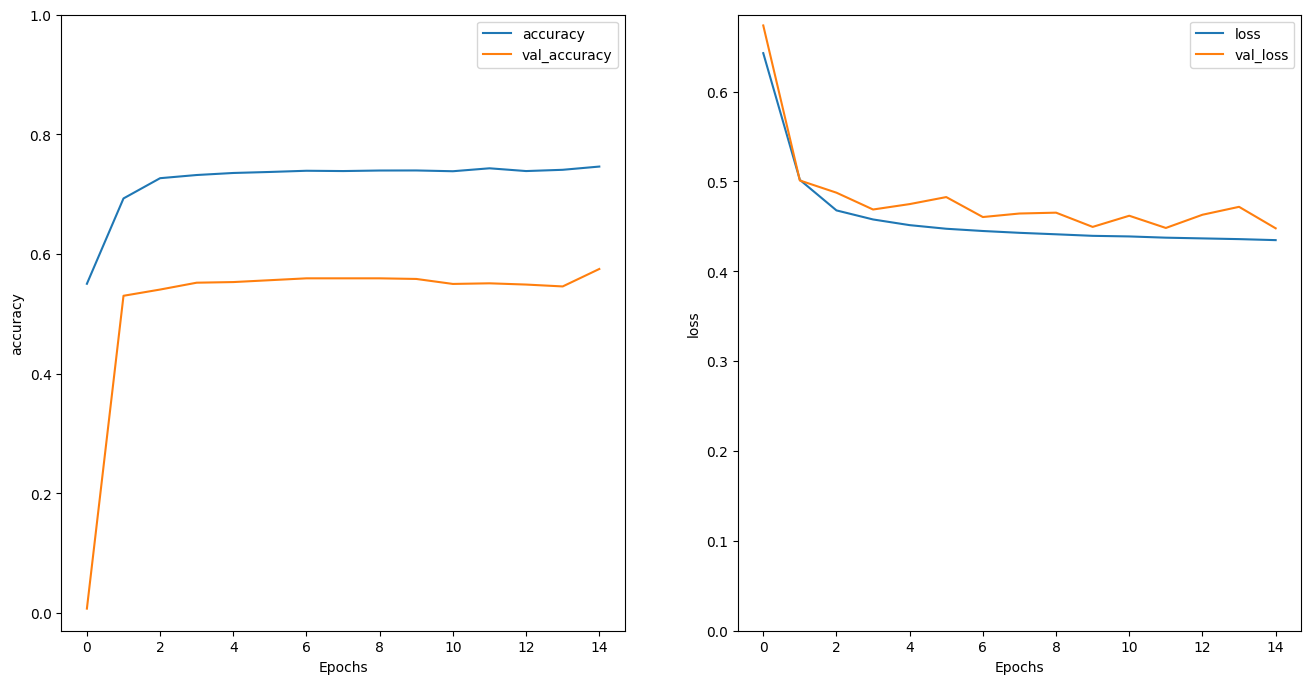

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [30]:
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[0.7807458]


##### Experiment 2: Use binary count vectorizer for encoding

In [31]:
model = create_model(encoder_multi_hot, 30)
# predict on a sample formula using untrained model
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[0.00495063]


In [32]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15

sample_text = "( A \cup B ) \cap (C \cup D )"
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [33]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "2-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "multi_hot",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
155/156 [============================>.] - ETA: 0s - loss: 0.6914 - accuracy: 0.5503INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192420-wvv1dogd/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192420-wvv1dogd/files/model-best/assets


156/156 [==============================] - 24s 121ms/step - loss: 0.6914 - accuracy: 0.5499 - val_loss: 0.7387 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - 5s 31ms/step - loss: 0.6892 - accuracy: 0.5500 - val_loss: 0.7646 - val_accuracy: 0.0000e+00
Epoch 3/15
156/156 [==============================] - 5s 34ms/step - loss: 0.6831 - accuracy: 0.5499 - val_loss: 0.7450 - val_accuracy: 0.0000e+00
Epoch 4/15
156/156 [==============================] - 5s 32ms/step - loss: 0.6682 - accuracy: 0.5494 - val_loss: 0.7572 - val_accuracy: 0.0510
Epoch 5/15
156/156 [==============================] - 5s 31ms/step - loss: 0.6583 - accuracy: 0.6174 - val_loss: 0.8157 - val_accuracy: 0.2385
Epoch 6/15
156/156 [==============================] - 5s 34ms/step - loss: 0.6537 - accuracy: 0.6214 - val_loss: 0.8067 - val_accuracy: 0.2896
Epoch 7/15
156/156 [==============================] - 6s 39ms/step - loss: 0.6510 - accuracy: 0.6210 - val_loss: 0.7773 - val_accuracy: 0.2

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192420-wvv1dogd/files/model-best/assets


156/156 [==============================] - 19s 122ms/step - loss: 0.6462 - accuracy: 0.6219 - val_loss: 0.7298 - val_accuracy: 0.2896
Epoch 13/15
156/156 [==============================] - 5s 31ms/step - loss: 0.6462 - accuracy: 0.6193 - val_loss: 0.7678 - val_accuracy: 0.2385
Epoch 14/15
156/156 [==============================] - 5s 30ms/step - loss: 0.6455 - accuracy: 0.6225 - val_loss: 0.7346 - val_accuracy: 0.2896
Epoch 15/15
156/156 [==============================] - 5s 30ms/step - loss: 0.6449 - accuracy: 0.6216 - val_loss: 0.7584 - val_accuracy: 0.2385


In [34]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 11ms/step - loss: 0.7584 - accuracy: 0.2385
Test Loss: 0.7584447264671326
Test Accuracy: 0.23854166269302368


(0.0, 0.8242839336395263)

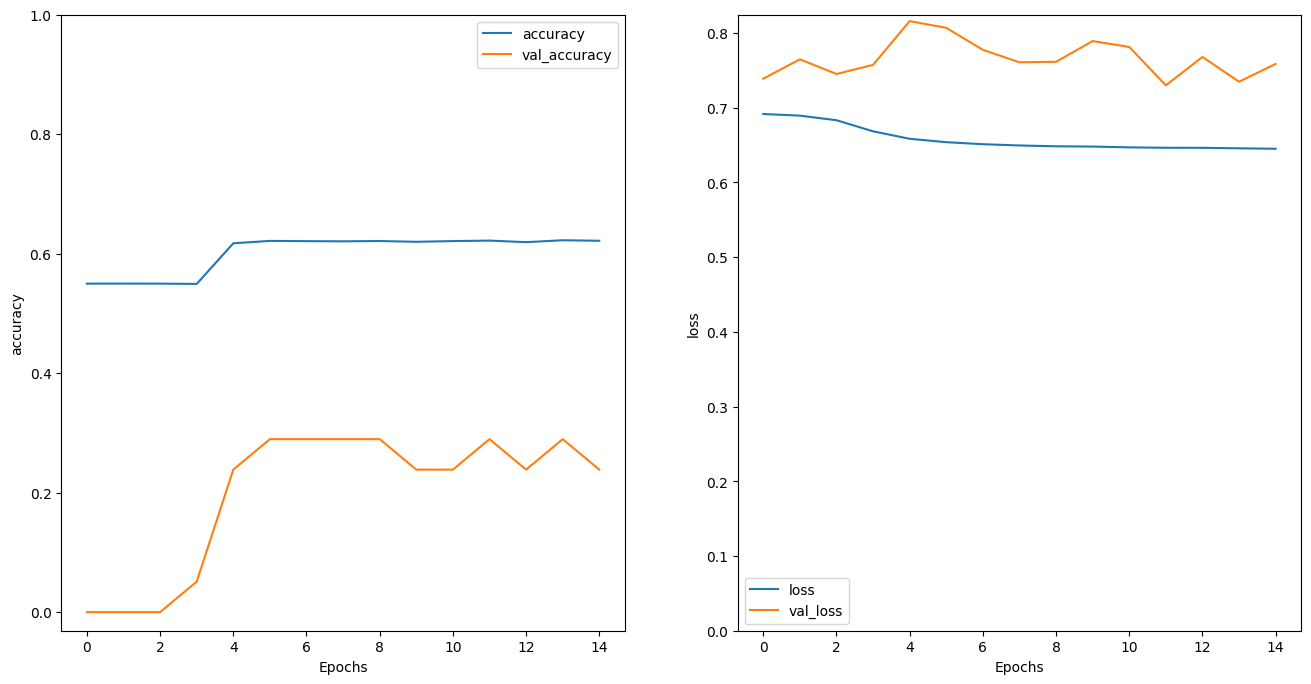

In [35]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [36]:
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.09123264]


##### Experiment 3:

In [37]:
model = create_model(encoder_count, 30)
# predict on a sample formula using untrained model
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.01303172]


In [38]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15

sample_text = "( A \cup B ) \cap (C \cup D )"
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [39]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "2-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.5498INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


156/156 [==============================] - 25s 129ms/step - loss: 0.6880 - accuracy: 0.5498 - val_loss: 0.7288 - val_accuracy: 0.0000e+00
Epoch 2/15
155/156 [============================>.] - ETA: 0s - loss: 0.6650 - accuracy: 0.5492INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


156/156 [==============================] - 19s 124ms/step - loss: 0.6650 - accuracy: 0.5496 - val_loss: 0.7172 - val_accuracy: 0.0000e+00
Epoch 3/15
155/156 [============================>.] - ETA: 0s - loss: 0.6451 - accuracy: 0.5557INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


156/156 [==============================] - 20s 128ms/step - loss: 0.6451 - accuracy: 0.5558 - val_loss: 0.6964 - val_accuracy: 0.0885
Epoch 4/15
156/156 [==============================] - 5s 35ms/step - loss: 0.6366 - accuracy: 0.6015 - val_loss: 0.7033 - val_accuracy: 0.3156
Epoch 5/15
156/156 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.6445INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


156/156 [==============================] - 20s 126ms/step - loss: 0.6283 - accuracy: 0.6445 - val_loss: 0.6886 - val_accuracy: 0.3521
Epoch 6/15
156/156 [==============================] - 5s 30ms/step - loss: 0.6220 - accuracy: 0.6436 - val_loss: 0.7140 - val_accuracy: 0.3521
Epoch 7/15
156/156 [==============================] - 5s 31ms/step - loss: 0.6178 - accuracy: 0.6458 - val_loss: 0.7267 - val_accuracy: 0.3146
Epoch 8/15
156/156 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.6448INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


156/156 [==============================] - 19s 120ms/step - loss: 0.6149 - accuracy: 0.6448 - val_loss: 0.6777 - val_accuracy: 0.3562
Epoch 9/15
156/156 [==============================] - 5s 31ms/step - loss: 0.6104 - accuracy: 0.6432 - val_loss: 0.6924 - val_accuracy: 0.3135
Epoch 10/15
156/156 [==============================] - 5s 31ms/step - loss: 0.6052 - accuracy: 0.6441 - val_loss: 0.6792 - val_accuracy: 0.3167
Epoch 11/15
156/156 [==============================] - 5s 32ms/step - loss: 0.6004 - accuracy: 0.6445 - val_loss: 0.7205 - val_accuracy: 0.2885
Epoch 12/15
156/156 [==============================] - 5s 31ms/step - loss: 0.5964 - accuracy: 0.6451 - val_loss: 0.7046 - val_accuracy: 0.2917
Epoch 13/15
156/156 [==============================] - 5s 31ms/step - loss: 0.5933 - accuracy: 0.6459 - val_loss: 0.6826 - val_accuracy: 0.2969
Epoch 14/15
155/156 [============================>.] - ETA: 0s - loss: 0.5904 - accuracy: 0.6493INFO:tensorflow:Assets written to: /home/paul_d/Sou

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_192622-sujpx6p7/files/model-best/assets


156/156 [==============================] - 19s 124ms/step - loss: 0.5903 - accuracy: 0.6492 - val_loss: 0.6511 - val_accuracy: 0.3229
Epoch 15/15
156/156 [==============================] - 5s 30ms/step - loss: 0.5883 - accuracy: 0.6510 - val_loss: 0.6632 - val_accuracy: 0.3187


In [40]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 11ms/step - loss: 0.6632 - accuracy: 0.3187
Test Loss: 0.6632261872291565
Test Accuracy: 0.3187499940395355


(0.0, 0.7357930809259414)

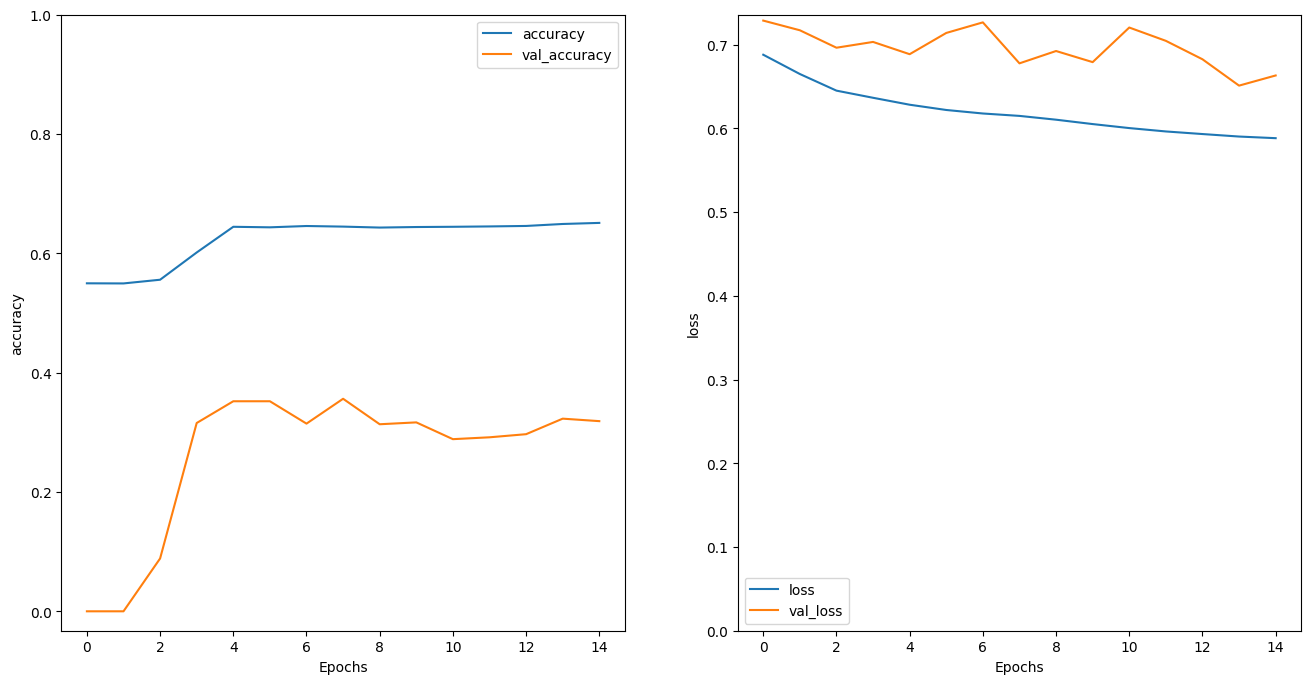

In [41]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [42]:
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.8138238]


##### Experiment 4:

In [43]:
model = create_model(encoder_bigrams, 30)
# predict on a sample formula using untrained model
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[0.00264617]


In [44]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15

sample_text = "( A \cup B ) \cap (C \cup D )"
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 355)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 355, 64)           24640     
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 99,009
Trainable params: 99,009
Non-trai

In [46]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "2-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "bigram_count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.5503INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


156/156 [==============================] - 47s 274ms/step - loss: 0.6879 - accuracy: 0.5503 - val_loss: 0.7179 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - ETA: 0s - loss: 0.6642 - accuracy: 0.5531INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


156/156 [==============================] - 45s 287ms/step - loss: 0.6642 - accuracy: 0.5531 - val_loss: 0.7086 - val_accuracy: 0.2677
Epoch 3/15
156/156 [==============================] - 28s 177ms/step - loss: 0.6308 - accuracy: 0.6400 - val_loss: 0.7580 - val_accuracy: 0.3052
Epoch 4/15
156/156 [==============================] - ETA: 0s - loss: 0.6241 - accuracy: 0.6425INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


156/156 [==============================] - 42s 267ms/step - loss: 0.6241 - accuracy: 0.6425 - val_loss: 0.6718 - val_accuracy: 0.3198
Epoch 5/15
156/156 [==============================] - 28s 182ms/step - loss: 0.6191 - accuracy: 0.6453 - val_loss: 0.7086 - val_accuracy: 0.3198
Epoch 6/15
156/156 [==============================] - 32s 203ms/step - loss: 0.6137 - accuracy: 0.6438 - val_loss: 0.7050 - val_accuracy: 0.3083
Epoch 7/15
156/156 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.6431INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


156/156 [==============================] - 46s 297ms/step - loss: 0.6090 - accuracy: 0.6431 - val_loss: 0.6689 - val_accuracy: 0.3208
Epoch 8/15
156/156 [==============================] - 28s 177ms/step - loss: 0.6040 - accuracy: 0.6424 - val_loss: 0.7046 - val_accuracy: 0.2906
Epoch 9/15
156/156 [==============================] - 29s 188ms/step - loss: 0.6002 - accuracy: 0.6469 - val_loss: 0.7446 - val_accuracy: 0.2833
Epoch 10/15
156/156 [==============================] - ETA: 0s - loss: 0.5978 - accuracy: 0.6438INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


156/156 [==============================] - 44s 284ms/step - loss: 0.5978 - accuracy: 0.6438 - val_loss: 0.6679 - val_accuracy: 0.2969
Epoch 11/15
156/156 [==============================] - 31s 202ms/step - loss: 0.5960 - accuracy: 0.6457 - val_loss: 0.6771 - val_accuracy: 0.2958
Epoch 12/15
156/156 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.6448INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


156/156 [==============================] - 44s 284ms/step - loss: 0.5956 - accuracy: 0.6448 - val_loss: 0.6442 - val_accuracy: 0.2979
Epoch 13/15
156/156 [==============================] - 26s 164ms/step - loss: 0.5924 - accuracy: 0.6468 - val_loss: 0.6665 - val_accuracy: 0.2969
Epoch 14/15
156/156 [==============================] - ETA: 0s - loss: 0.5920 - accuracy: 0.6452INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_193031-7fl0vyqb/files/model-best/assets


156/156 [==============================] - 44s 282ms/step - loss: 0.5920 - accuracy: 0.6452 - val_loss: 0.6020 - val_accuracy: 0.3000
Epoch 15/15
156/156 [==============================] - 29s 184ms/step - loss: 0.5910 - accuracy: 0.6456 - val_loss: 0.6609 - val_accuracy: 0.2969


In [47]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 1s 69ms/step - loss: 0.6609 - accuracy: 0.2969
Test Loss: 0.6609039902687073
Test Accuracy: 0.296875


(0.0, 0.7663837283849716)

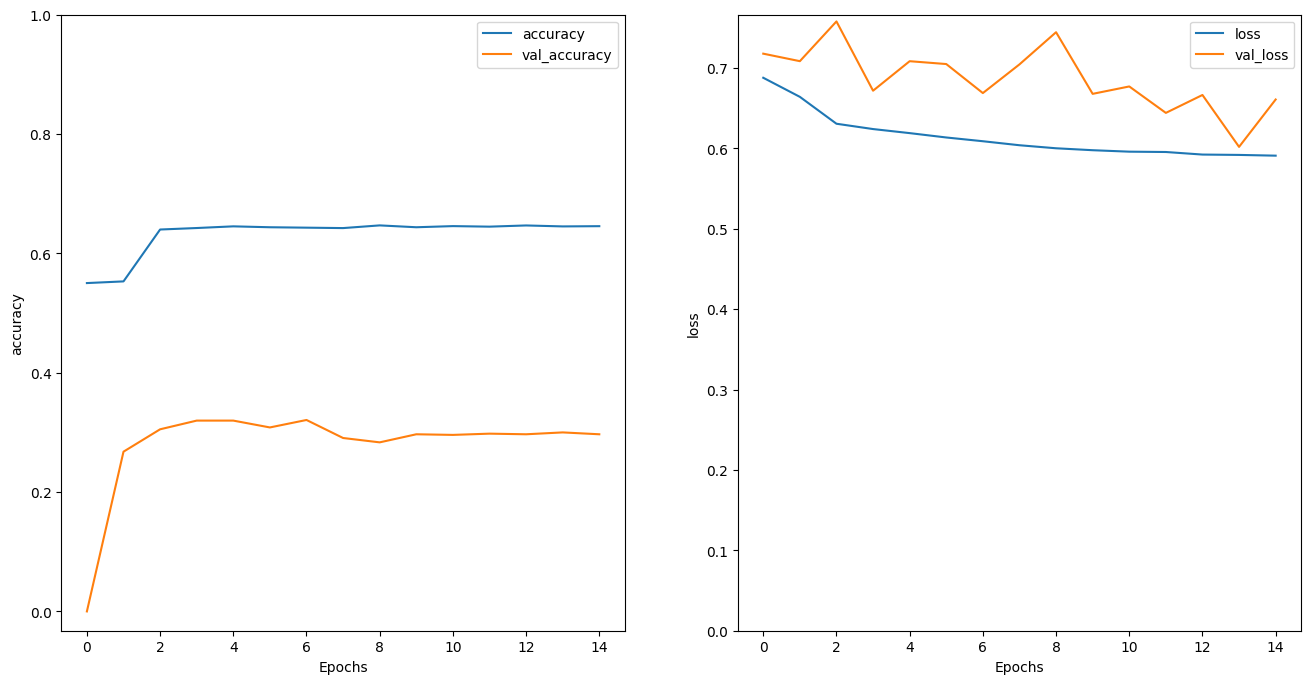

In [48]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [49]:
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.30307266]


##### Experiment 5:

In [50]:
model_tf_idf = create_model(encoder_tf_idf,30)
# predict on a sample formula using untrained model
predictions = model_tf_idf.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.00110074]


In [51]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15
sample_text = "set_constant SET_BASIC"

model_tf_idf.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [52]:
model_tf_idf.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, 58)               1         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 58, 64)            5632      
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 80,002
Trainable params: 80,001
Non-trai

In [53]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "BiLstm",
    "configuration": "2-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "tf_idf",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model_tf_idf.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6699 - accuracy: 0.5501INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_194025-yrf91qoz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_194025-yrf91qoz/files/model-best/assets


156/156 [==============================] - 25s 131ms/step - loss: 0.6699 - accuracy: 0.5501 - val_loss: 0.6852 - val_accuracy: 0.0000e+00
Epoch 2/15
155/156 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.6546INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_194025-yrf91qoz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_194025-yrf91qoz/files/model-best/assets


156/156 [==============================] - 20s 129ms/step - loss: 0.5827 - accuracy: 0.6553 - val_loss: 0.5784 - val_accuracy: 0.3875
Epoch 3/15
156/156 [==============================] - 5s 34ms/step - loss: 0.5453 - accuracy: 0.6839 - val_loss: 0.5842 - val_accuracy: 0.3677
Epoch 4/15
156/156 [==============================] - 6s 36ms/step - loss: 0.5355 - accuracy: 0.6835 - val_loss: 0.5905 - val_accuracy: 0.3667
Epoch 5/15
156/156 [==============================] - 5s 34ms/step - loss: 0.5314 - accuracy: 0.6841 - val_loss: 0.5833 - val_accuracy: 0.3677
Epoch 6/15
156/156 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.6856INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_194025-yrf91qoz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_194025-yrf91qoz/files/model-best/assets


156/156 [==============================] - 20s 130ms/step - loss: 0.5286 - accuracy: 0.6856 - val_loss: 0.5714 - val_accuracy: 0.3688
Epoch 7/15
156/156 [==============================] - 5s 33ms/step - loss: 0.5260 - accuracy: 0.6909 - val_loss: 0.5923 - val_accuracy: 0.3677
Epoch 8/15
156/156 [==============================] - 5s 34ms/step - loss: 0.5239 - accuracy: 0.6925 - val_loss: 0.5883 - val_accuracy: 0.3938
Epoch 9/15
156/156 [==============================] - 6s 36ms/step - loss: 0.5211 - accuracy: 0.6953 - val_loss: 0.6052 - val_accuracy: 0.3906
Epoch 10/15
156/156 [==============================] - 5s 32ms/step - loss: 0.5189 - accuracy: 0.6993 - val_loss: 0.5781 - val_accuracy: 0.3938
Epoch 11/15
156/156 [==============================] - 6s 36ms/step - loss: 0.5152 - accuracy: 0.7024 - val_loss: 0.5957 - val_accuracy: 0.3896
Epoch 12/15
155/156 [============================>.] - ETA: 0s - loss: 0.5118 - accuracy: 0.7065INFO:tensorflow:Assets written to: /home/paul_d/Sourc

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_194025-yrf91qoz/files/model-best/assets


156/156 [==============================] - 21s 137ms/step - loss: 0.5122 - accuracy: 0.7066 - val_loss: 0.5674 - val_accuracy: 0.4167
Epoch 13/15
156/156 [==============================] - 6s 38ms/step - loss: 0.5092 - accuracy: 0.7209 - val_loss: 0.5775 - val_accuracy: 0.4156
Epoch 14/15
156/156 [==============================] - 5s 33ms/step - loss: 0.5071 - accuracy: 0.7143 - val_loss: 0.5713 - val_accuracy: 0.4115
Epoch 15/15
156/156 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.7186INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_194025-yrf91qoz/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230306_194025-yrf91qoz/files/model-best/assets


156/156 [==============================] - 19s 123ms/step - loss: 0.5052 - accuracy: 0.7186 - val_loss: 0.5329 - val_accuracy: 0.7344


In [54]:
test_loss, test_acc = model_tf_idf.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 12ms/step - loss: 0.5329 - accuracy: 0.7344
Test Loss: 0.5328635573387146
Test Accuracy: 0.734375


(0.0, 0.6941743165254592)

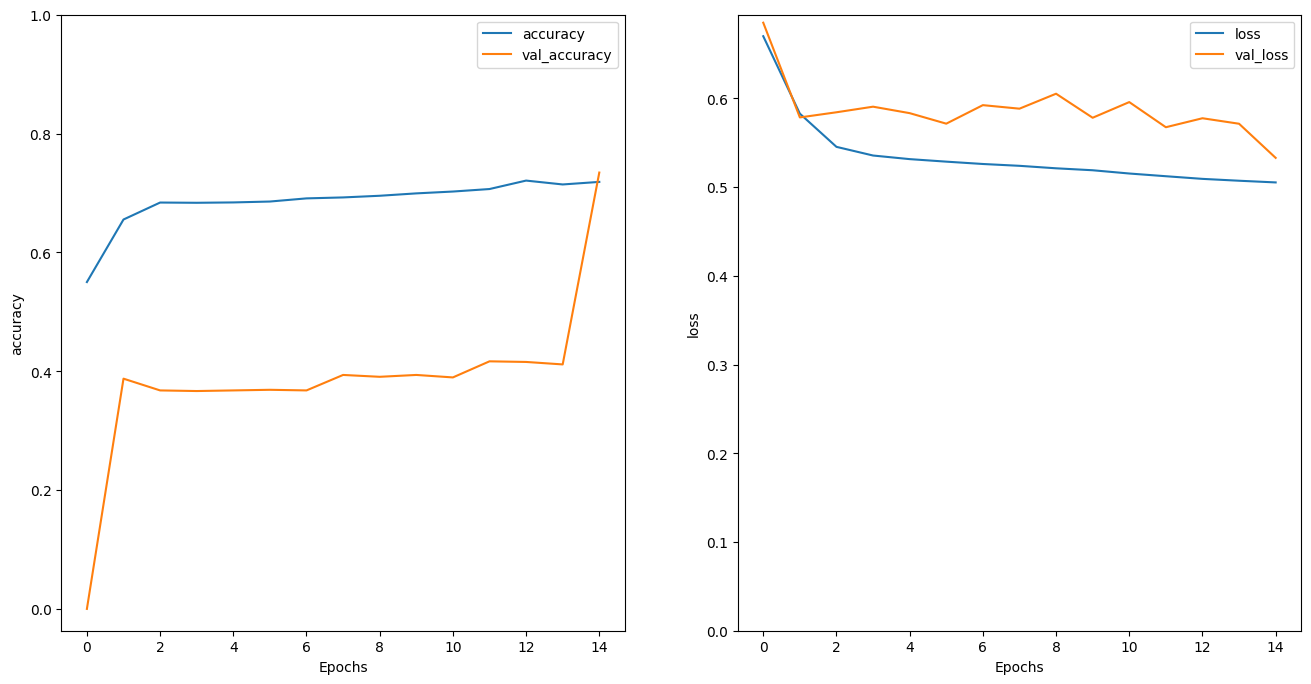

In [55]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [61]:
# predict on a sample text without padding
sample_text = "set_constant SET_BASIC"
predictions = model_tf_idf.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 17ms/step
[-1.0408258]
